# Part 2: Advanced Configuration

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import sys
import os
# Add the directory containing callbacks.py to sys.path
sys.path.append(os.path.join(os.getcwd(), "hls4ml-tutorial_OPENML"))
import plotting

# Simulate sourcing the script to set variables (as a fallback)
os.environ['XILINX_VITIS'] = '/opt/local/Vitis_HLS/2024.1'  # Adjust this path as needed
# Update the PATH variable
os.environ['PATH'] = os.path.join(os.environ['XILINX_VITIS'], 'bin') + ':' + os.environ.get('PATH', '')

2025-02-25 17:08:05.538536: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the dataset

In [2]:
X_train_val = np.load('X_train_val.npy')
X_test = np.ascontiguousarray(np.load('X_test.npy'))
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy', allow_pickle=True)
classes = np.load('classes.npy', allow_pickle=True)

## Load the model
Load the model trained in 'part1_getting_started'. **Make sure you've run through that walkthrough first!**

In [3]:
from tensorflow.keras.models import load_model

model = load_model('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/KERAS_check_best_model.h5')
y_keras = model.predict(X_test)

5188/5188 [==============================] - 3s 643us/step


## Make an hls4ml config & model
This time, we'll create a config with finer granularity. When we print the config dictionary, you'll notice that an entry is created for each named Layer of the model. See for the first layer, for example:
```LayerName:
    fc1:
        Precision:
            weight: ap_fixed<16,6>
            bias:   ap_fixed<16,6>
            result: ap_fixed<16,6>
        ReuseFactor: 1
```
Taken 'out of the box' this config will set all the parameters to the same settings as in part 1, but we can use it as a template to start modifying things. 

In [4]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='name', backend='Vitis')
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
-----------------------------------
Model
  Precision
    default:         fixed<16,6>
  ReuseFactor:       1
  Strategy:      

/home/hep/lr1424/miniforge3/envs/hls4ml-tutorial/lib/python3.10/site-packages/hls4ml/converters/__init__.py:28: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


## Profiling
As you can see, we can choose the precision of _everything_ in our Neural Network. This is a powerful way to tune the performance, but it's also complicated. The tools in `hls4ml.model.profiling` can help you choose the right precision for your model. (That said, training your model with quantization built in can get around this problem, and that is introduced in Part 4. So, don't go too far down the rabbit hole of tuning your data types without first trying out quantization aware training with QKeras.)

The first thing to try is to numerically profile your model. This method plots the distribution of the weights (and biases) as a box and whisker plot. The grey boxes show the values which can be represented with the data types used in the `hls_model`. Generally, you need the box to overlap completely with the whisker 'to the right' (large values) otherwise you'll get saturation & wrap-around issues. It can be okay for the box not to overlap completely 'to the left' (small values), but finding how small you can go is a matter of trial-and-error.

Providing data, in this case just using the first 1000 examples for speed, will show the same distributions captured at the output of each layer.

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
Creating HLS model
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]],

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>)

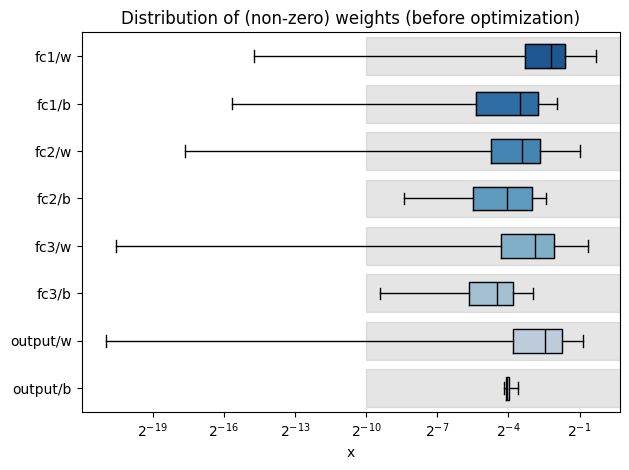

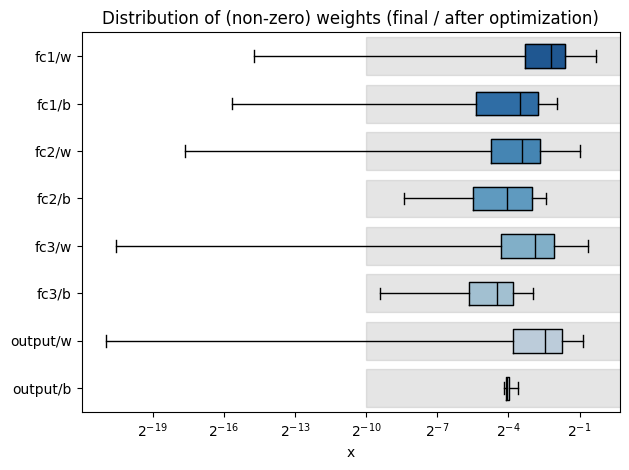

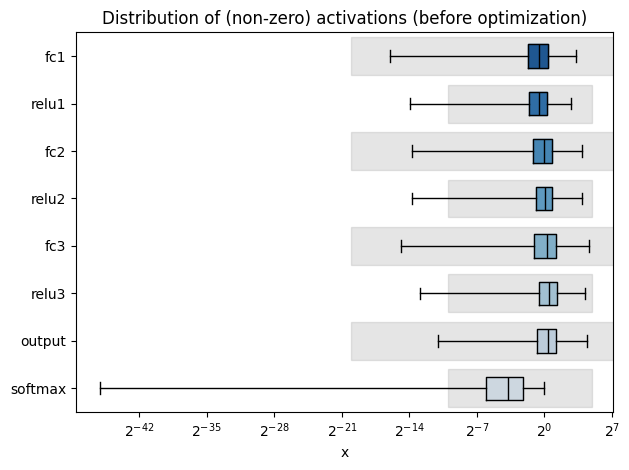

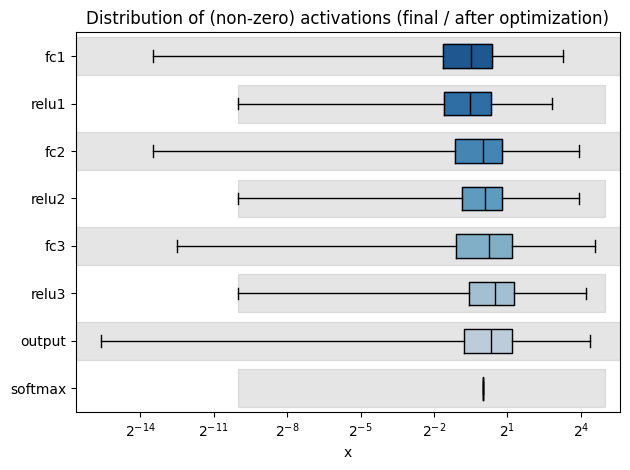

In [5]:
%matplotlib inline
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj_2', part='xcu250-figd2104-2L-e'
)
hls4ml.model.profiling.numerical(model=model, hls_model=hls_model, X=X_test[:1000])

## Customize
Let's just try setting the precision of the first layer weights to something more narrow than 16 bits. Using fewer bits can save resources in the FPGA. After inspecting the profiling plot above, let's try 8 bits with 1 integer bit.

Then create a new `HLSModel`, and display the profiling with the new config. This time, just display the weight profile by not providing any data '`X`'. Then create the `HLSModel` and display the architecture. Notice the box around the weights of the first layer reflects the different precision.

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
Creating HLS model
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]],

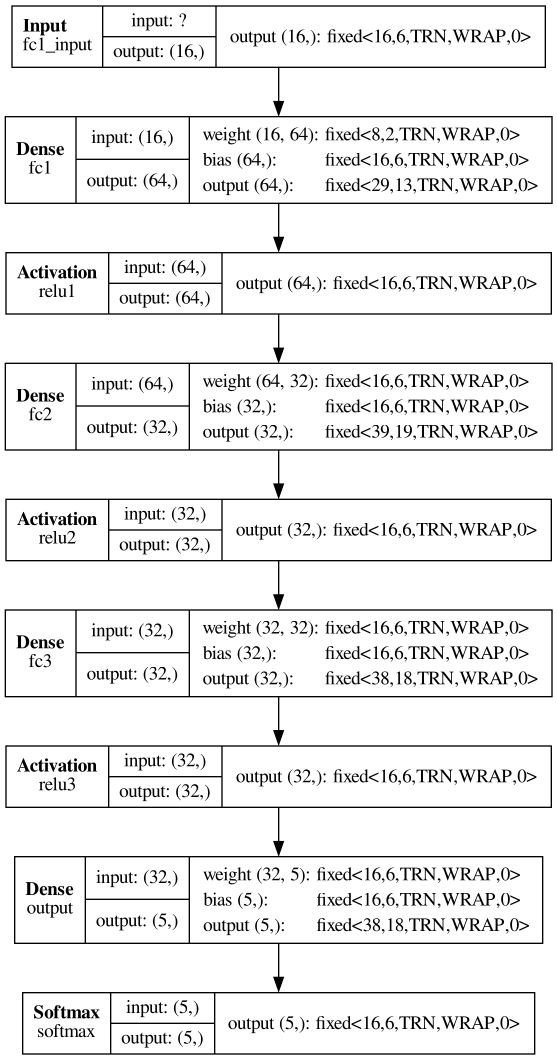

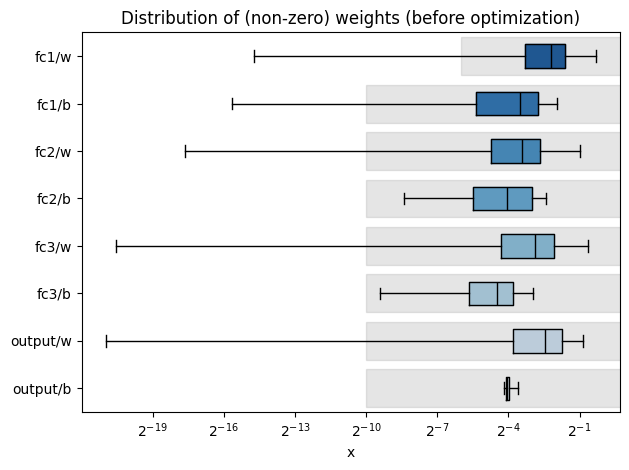

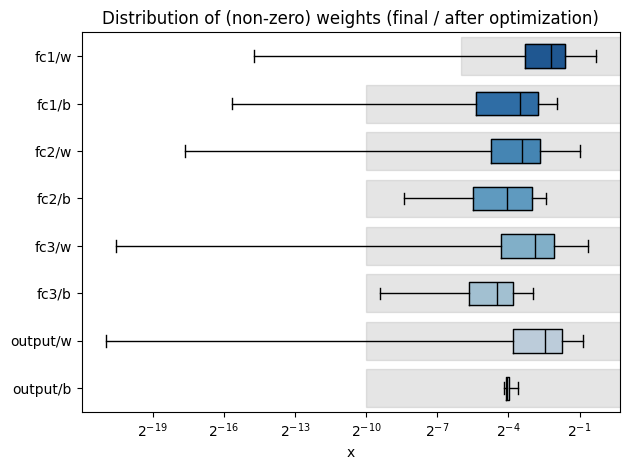

In [6]:
config['LayerName']['fc1']['Precision']['weight'] = 'ap_fixed<8,2>'
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj_2', part='xcu250-figd2104-2L-e'
)
hls4ml.model.profiling.numerical(model=model, hls_model=hls_model)
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

## Trace
When we start using customised precision throughout the model, it can be useful to collect the output from each layer to find out when things have gone wrong. We enable this trace collection by setting `Trace = True` for each layer whose output we want to collect.

In [7]:
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='Vitis', output_dir='/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj_2', part='xcu250-figd2104-2L-e'
)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
Creating HLS model


## Compile, trace, predict
Now we need to check that this model performance is still good after reducing the precision. We compile the `hls_model`, and now use the `hls_model.trace` method to collect the model output, and also the output for all the layers we enabled tracing for. This returns a dictionary with keys corresponding to the layer names of the model. Stored at that key is the array of values output by that layer, sampled from the provided data.
A helper function `get_ymodel_keras` will return the same dictionary for the Keras model.

We'll just run the `trace` for the first 1000 examples, since it takes a bit longer and uses more memory than just running `predict`. 

In [8]:
hls_model.compile()
hls4ml_pred, hls4ml_trace = hls_model.trace(X_test[:1000])
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, X_test[:1000])
y_hls = hls_model.predict(X_test)

Writing HLS project
Done
Recompiling myproject with tracing
Writing HLS project
Done
32/32 [==============================] - 0s 839us/step
Done taking outputs for Keras model.


## Inspect
Now we can print out, make plots, or do any other more detailed analysis on the output of each layer to make sure we haven't made the performance worse. And if we have, we can quickly find out where. Let's just print the output of the first layer, for the first sample, for both the Keras and hls4ml models.

In [9]:
print("Keras layer 'fc1', first sample:")
print(keras_trace['fc1'][0])
print("hls4ml layer 'fc1', first sample:")
print(hls4ml_trace['fc1'][0])

Keras layer 'fc1', first sample:
[ 0.23277071 -1.5298398   2.1827824   1.6547451   0.50228566  0.6508671
  0.68213564 -0.17688608  0.07171608  0.23036563  1.5005565  -0.8694629
  1.0139289   1.187984    1.2613657  -1.6590788  -0.9790535   1.8891172
 -0.7465105  -2.1404605   1.344431    0.81816393  1.0680834   1.1645067
 -0.9748621   0.67590386  0.47515368  0.31403548  2.8503904   1.667803
  1.8777531   0.4004348   3.0575662   0.57126594  2.0562234  -0.06320575
  1.531616    1.1051995  -1.0496414   1.1640589   1.0585924  -0.01322068
  0.68866456 -0.5814071   0.4123844  -1.6368234   0.48434234 -2.3024235
  1.9178324  -0.3904893  -0.6480408  -2.0480874  -1.9813569   2.0145621
 -2.5158186  -1.1002909  -0.00350231 -1.1508918  -0.3831729  -0.33084628
  0.07276732 -1.4233556   0.2148312   0.6473142 ]
hls4ml layer 'fc1', first sample:
[ 2.09945679e-01 -1.55528259e+00  2.15504456e+00  1.61863708e+00
  4.85580444e-01  6.07421875e-01  6.43890381e-01 -1.87744141e-01
  5.95092773e-04  2.02636719e-0

## Compare
Let's see if we lost performance by using 8 bits for the weights of the first layer by inspecting the accuracy and ROC curve.

Keras  Accuracy: 0.7340240963855422
hls4ml Accuracy: 0.7338373493975904


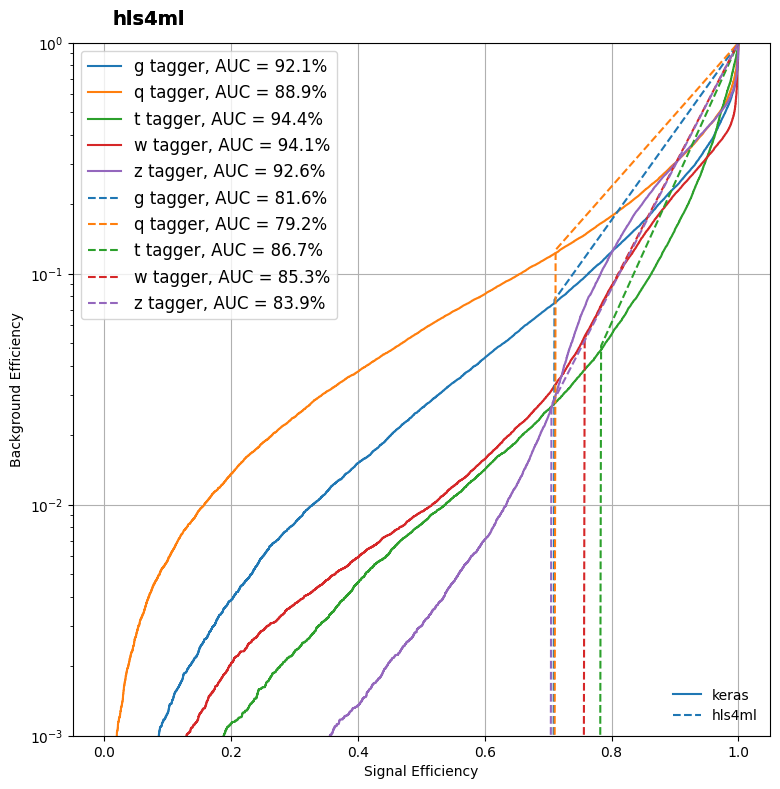

In [10]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, classes, linestyle='--')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['keras', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)

## Profiling & Trace Summary
We lost a small amount of accuracy compared to when we used `ap_fixed<16,6>`, but in many cases this difference will be small enough to be worth the resource saving. You can choose how aggressive to go with quantization, but it's always sensible to make the profiling plots even with the default configuration. Layer-level `trace` is very useful for finding when you reduced the bitwidth too far, or when the default configuration is no good for your model.

With this 'post training quantization', around 8-bits width generally seems to be the limit to how low you can go before suffering significant performance loss. In Part 4, we'll look at using 'training aware quantization' with QKeras to go much lower without losing much performance.

## ReuseFactor
Now let's look at the other configuration parameter: `ReuseFactor`.
Recall that `ReuseFactor` is our mechanism for tuning the parallelism:

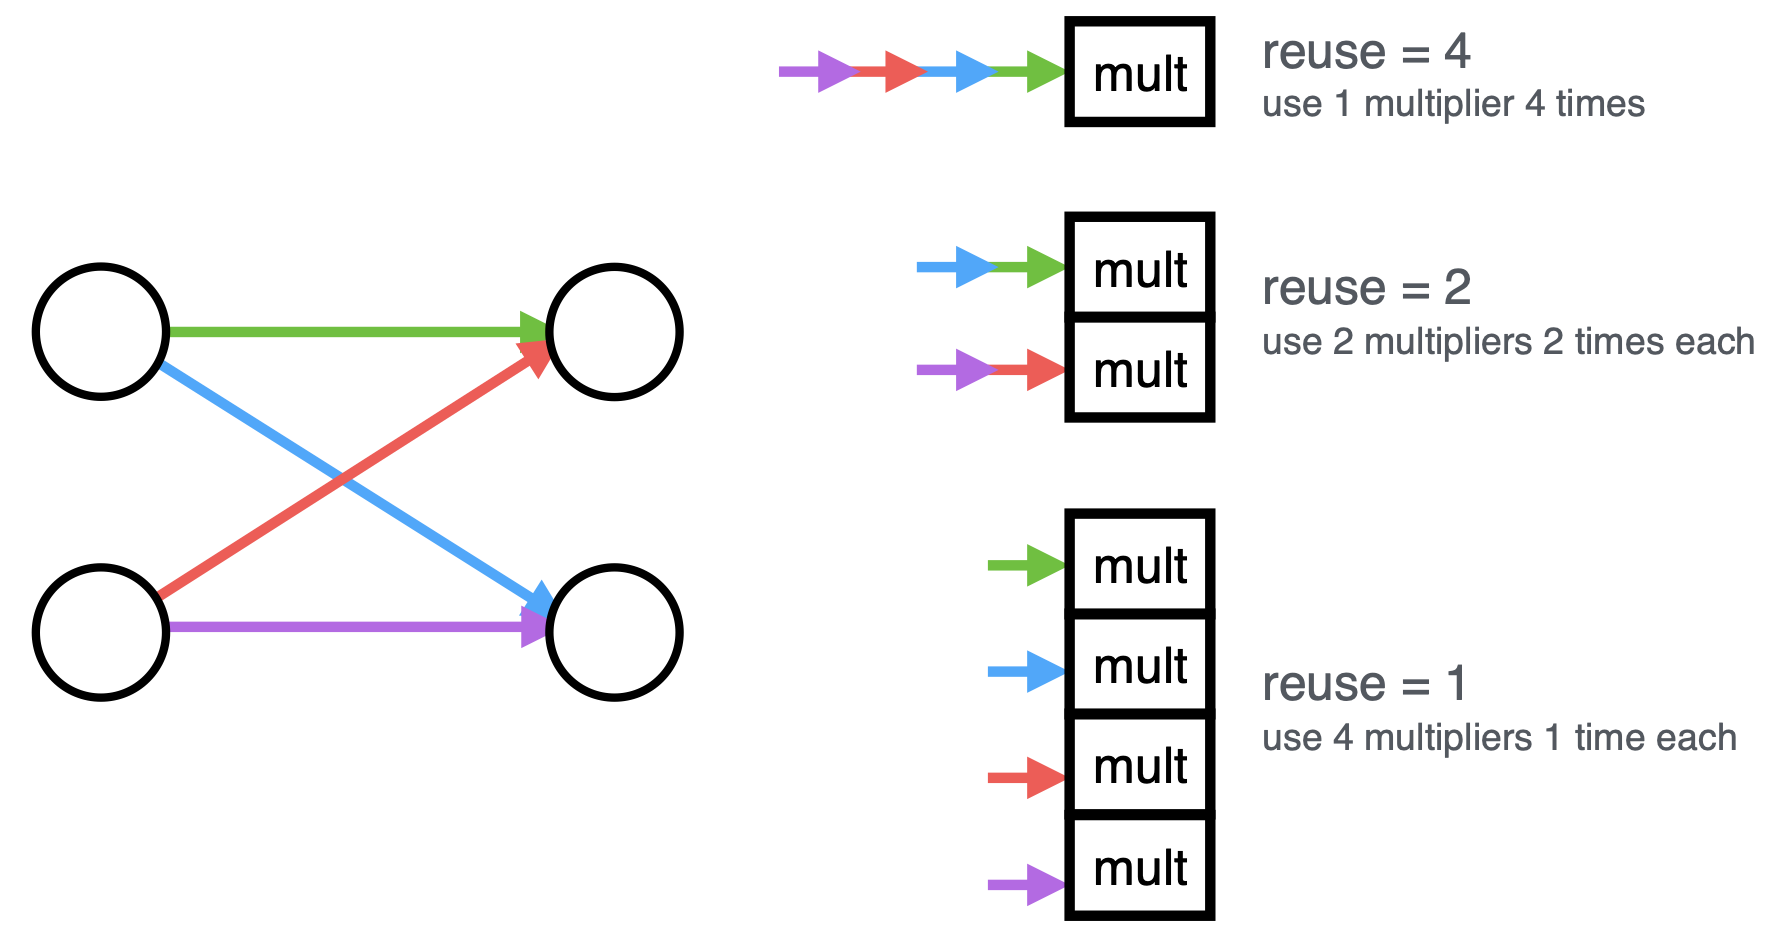

So now let's make a new configuration for this model, and set the `ReuseFactor` to `2` for every layer:
we'll compile the model, then evaulate its performance. (Note, by creating a new config with `granularity=Model`, we're implicitly resetting the precision to `ap_fixed<16,6>` throughout.) Changing the `ReuseFactor` should not change the classification results, but let's just verify that by inspecting the accuracy and ROC curve again!
Then we'll build the model.

In [ ]:
config = hls4ml.utils.config_from_keras_model(model, granularity='Model', backend='Vitis')
print("-----------------------------------")
print(config)
print("-----------------------------------")

# Set the ReuseFactor to 2 
config['Model']['ReuseFactor'] = 2
hls_model_rf2 = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='vitis', output_dir='/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj_3', part='xcu250-figd2104-2L-e'
)
hls_model_rf2.compile()
y_hls_rf2 = hls_model_rf2.predict(X_test)

# Set the ReuseFactor to 6
config['Model']['ReuseFactor'] = 6
hls_model_rf6 = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='vitis', output_dir='/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj_4', part='xcu250-figd2104-2L-e'
)
hls_model_rf6.compile()
y_hls_rf6 = hls_model_rf6.predict(X_test)

# Set the ReuseFactor to 10
config['Model']['ReuseFactor'] = 10
hls_model_rf10 = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='vitis', output_dir='/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj_5', part='xcu250-figd2104-2L-e'
)
hls_model_rf10.compile()
hls_model_rf10.build(csim=True)
y_hls_rf10 = hls_model_rf10.predict(X_test)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
Creating HLS model
Writing HLS project
Done

****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2024.1 (64-bit)
  

### NB: Zero change to efficiency from ReuseFactor - RF = 2 and RF = 10 exactly match

In [17]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml_rf1 Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))
print("hls4ml_rf6 Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls_rf6, axis=1))))
print("hls4ml_rf2 Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls_rf2, axis=1))))
print("hls4ml_rf10 Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls_rf10, axis=1))))

fig,ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, classes, linestyle='--')
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls_rf2, classes, linestyle='-.')
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls_rf10, classes, linestyle=':')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--'), Line2D([0], [0], ls='-.'),
         Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['Keras', 'Reuse Factor = 1', 'Reuse Factor = 2', 'Reuse Factor = 10'], loc='lower right', frameon=False)
ax.add_artist(leg)

Keras  Accuracy: 0.7340240963855422
hls4ml_rf1 Accuracy: 0.7338373493975904
hls4ml_rf6 Accuracy: 0.7337409638554216


NameError: name 'y_hls_rf2' is not defined

Now build the model

**This can take several minutes.**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_1/hls4ml_prj_2/vitis_hls.log`

In [ ]:
# hls_model.build(csim=False)

In [ ]:
hls_model_rf2.build(csim=False)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2024.1 (64-bit)
  **** SW Build 5069499 on May 21 2024
  **** IP Build 5075265 on Wed May 22 21:45:21 MDT 2024
  **** SharedData Build 5076995 on Wed May 22 18:29:18 MDT 2024
  **** Start of session at: Fri Feb 21 17:56:01 2025
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2024 Advanced Micro Devices, Inc. All Rights Reserved.

source /opt/local/Vitis_HLS/2024.1/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] For user 'lr1424' on host 'lxfw00.hep.ph.ic.ac.uk' (Linux_x86_64 version 5.14.0-503.15.1.el9_5.x86_64) on Fri Feb 21 17:56:03 GMT 2025
INFO: [HLS 200-10] On os "Rocky Linux 9.5 (Blue Onyx)"
INFO: [HLS 200-10] In directory '/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj_3'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Opening project '/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj_3/myp

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '3.636',
  'BestLatency': '19',
  'WorstLatency': '19',
  'IntervalMin': '2',
  'IntervalMax': '2',
  'BRAM_18K': '8',
  'DSP': '2133',
  'FF': '33544',
  'LUT': '139782',
  'URAM': '0',
  'AvailableBRAM_18K': '5376',
  'AvailableDSP': '12288',
  'AvailableFF': '3456000',
  'AvailableLUT': '1728000',
  'AvailableURAM': '1280'}}

In [ ]:
hls_model_rf6.build(csim=False)

In [ ]:
hls_model_rf10.build(csim=False)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2024.1 (64-bit)
  **** SW Build 5069499 on May 21 2024
  **** IP Build 5075265 on Wed May 22 21:45:21 MDT 2024
  **** SharedData Build 5076995 on Wed May 22 18:29:18 MDT 2024
  **** Start of session at: Fri Feb 21 17:58:49 2025
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2024 Advanced Micro Devices, Inc. All Rights Reserved.

source /opt/local/Vitis_HLS/2024.1/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] For user 'lr1424' on host 'lxfw00.hep.ph.ic.ac.uk' (Linux_x86_64 version 5.14.0-503.15.1.el9_5.x86_64) on Fri Feb 21 17:58:51 GMT 2025
INFO: [HLS 200-10] On os "Rocky Linux 9.5 (Blue Onyx)"
INFO: [HLS 200-10] In directory '/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj_4'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Opening project '/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj_4/myp

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '3.638',
  'BestLatency': '42',
  'WorstLatency': '42',
  'IntervalMin': '9',
  'IntervalMax': '9',
  'BRAM_18K': '8',
  'DSP': '432',
  'FF': '43145',
  'LUT': '143502',
  'URAM': '0',
  'AvailableBRAM_18K': '5376',
  'AvailableDSP': '12288',
  'AvailableFF': '3456000',
  'AvailableLUT': '1728000',
  'AvailableURAM': '1280'}}

And now print the report, compare this to the report from Exercise 1

In [ ]:
hls4ml.report.read_vivado_report('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj_2')

Project myproject_prj does not exist. Rerun "hls4ml build -p /home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj_2".


In [ ]:
hls4ml.report.read_vivado_report('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj_3')

Found 1 solution(s) in /home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj_3/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Fri Feb 21 17:58:43 2025

* Version:        2024.1 (Build 5069499 on May 21 2024)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  |  5.00 ns|  3.636 ns|     1.35 ns|
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+---------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline|
    |   min   |   max   |    min    |    max    | min | 

In [ ]:
hls4ml.report.read_vivado_report('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj_4')

Found 1 solution(s) in /home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj_4/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Fri Feb 21 18:01:17 2025

* Version:        2024.1 (Build 5069499 on May 21 2024)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  |  5.00 ns|  3.638 ns|     1.35 ns|
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+----------+----------+-----+-----+---------+
    |  Latency (cycles) |  Latency (absolute) |  Interval | Pipeline|
    |   min   |   max   |    min   |    max   | min | max | 

In [ ]:
hls4ml.report.read_vivado_report('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj')

Found 1 solution(s) in /home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Tue Feb 11 17:18:33 2025

* Version:        2024.1 (Build 5069499 on May 21 2024)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  |  5.00 ns|  3.636 ns|     1.35 ns|
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+---------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline|
    |   min   |   max   |    min    |    max    | min | ma

## Exercise
- Recall the outcome of the exercise of part 1 where we estimated how many DSPs our network should use.
How does this change now we've used `ReuseFactor = 2` for the network? Does the expectation match the report this time?